<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/keyuanren/RenTaGSim_GraphEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Type-Aware Graph Embedding

### Loading New Dataset

In [45]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the train data from the drive
id = '1s7ng3JypVvjtoUF8eUFPGroCTNtkxzIE'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('updated_train.zip')
#get the test data from the drive
id = '11FK00L91jajUW15hzjsskNkN0DRsS_yN'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('updated_test.zip')
!ls

sample_data  updated_test  updated_test.zip  updated_train  updated_train.zip


In [3]:
#if train and test exist do not run this part
#removing the dialog
%%capture
#unzip the file
!unzip updated_train.zip
!unzip updated_test.zip

### Data visualization

First graph: 28367.gexf


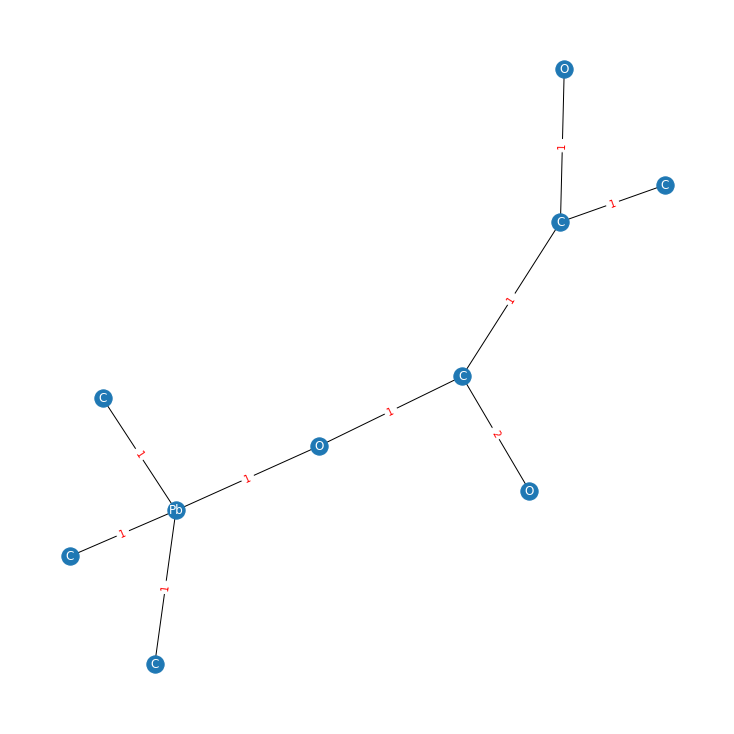

Second graph: 31432_28367.gexf


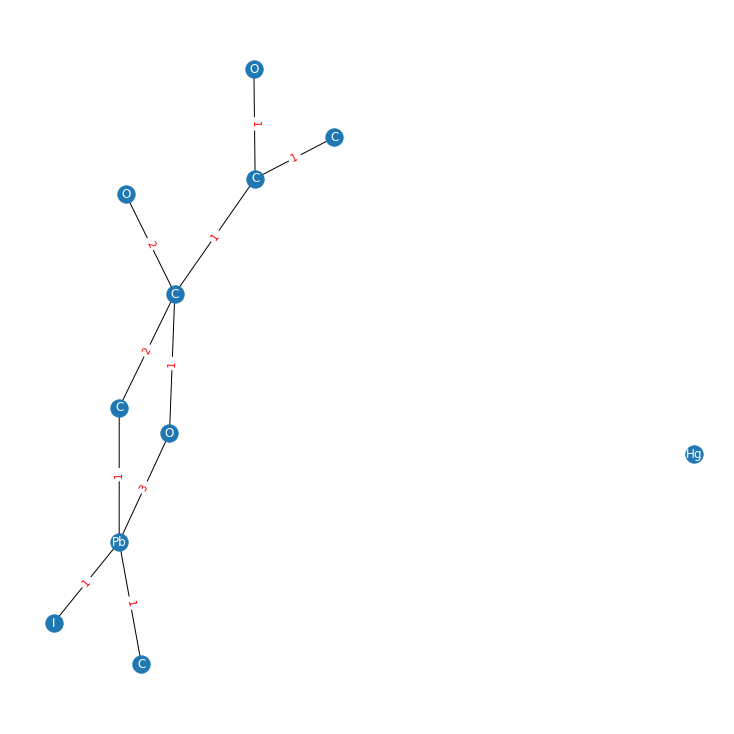

Their GED: 31432


In [33]:
# pick a pair graph
import os
import random
import matplotlib.pyplot as plt
import networkx as nx

dirName = 'updated_train/'
filenames = os.listdir(dirName)

#pick random pair
pair_1 = random.choice(filenames)
while '_' in pair_1:
  pair_1 = random.choice(filenames)
for filename in filenames:
    if filename.endswith("_"+pair_1):
      pair_2 = filename
      ged = pair_2.split('_', 1)[0]
#read pair 1
print("First graph: "+pair_1)
graph1 = nx.read_gexf('updated_train/'+pair_1,version='1.2draft')

node_info = nx.get_node_attributes(graph1, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph1.edges(data=True)])

#graph display
pos = nx.spring_layout(graph1, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph1, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph1, pos, edge_labels=edge_info, font_color="red")
plt.show()
#read pair 2
print("Second graph: "+pair_2)
graph2 = nx.read_gexf('updated_train/'+pair_2,version='1.2draft')

node_info = nx.get_node_attributes(graph2, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph2.edges(data=True)])

#graph display
pos = nx.spring_layout(graph2, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph2, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph2, pos, edge_labels=edge_info, font_color="red")
plt.show()
print("Their GED: "+ged)

###Type-Aware Graph Embedding

In [60]:
import torch
import numpy as np

def transform_label_multiset(graph1, graph2, ged):
  #node and edge info of pair graph
  node_info1 = nx.get_node_attributes(graph1, 'type')
  node_info2 = nx.get_node_attributes(graph2, 'type')
  edge_info1 = nx.get_edge_attributes(graph1, 'valence')
  edge_info2 = nx.get_edge_attributes(graph2, 'valence')
  nodes1 = list(graph1.nodes())
  nodes2 = list(graph2.nodes())
  edges1 = list(graph1.edges())
  edges2 = list(graph2.edges())
  print(node_info1)
  print(edge_info1)

  label_multiset  = dict()
  node_features_1, node_features_2, edge_features_1, edge_features_2, edge_adj_1, edge_adj_2 = [], [], [], [], [], []

  for i in nodes1:
    node_features_1.append([1.0])
  for i in nodes2:
    node_features_2.append([1.0])
  node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(np.array(node_features_2))

  for i in edges1:
    edge_features_1.append([1.0])
    adj_row = []
    for d in edges1:
        if(i == d):
            adj_row.append(0.0)
            continue
        if((i[0] in d) | (i[1] in d)):
            adj_row.append(1.0)
        else:
            adj_row.append(0.0)
    edge_adj_1.append(adj_row)
  for i in edges2:
    edge_features_2.append([1.0])
    adj_row = []
    for d in edges2:
        if(i == d):
            adj_row.append(0.0)
            continue
        if((i[0] in d) | (i[1] in d)):
            adj_row.append(1.0)
        else:
            adj_row.append(0.0)
    edge_adj_2.append(adj_row)
  edge_features_1, edge_features_2 = torch.FloatTensor(np.array(edge_features_1)), torch.FloatTensor(np.array(edge_features_2))
  edge_adj_1, edge_adj_2 = torch.FloatTensor(np.array(edge_adj_1)), torch.FloatTensor(np.array(edge_adj_2))

  label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
  label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
  label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
  label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

  #ged normalisation
  norm_ged = [ged.count(key) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())) for key in ['1', '2', '3', '4']]
  norm_ged = np.array(norm_ged)
  label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1,-1).float()

  norm_gt_ged = (len(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
  label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
  return label_multiset
  # edge_index_1 = nx.adjacency_matrix(graph1)
  # print("edge_index_1: ",edge_index_1.todense())

In [61]:
import pprint
label_multiset = transform_label_multiset(graph1, graph2, ged)
pprint.pprint(label_multiset)

{'7': 'C', '3': 'C', '5': 'O', '8': 'C', '6': 'C', '1': 'C', '9': 'O', '0': 'Pb', '4': 'O', '2': 'C'}
{('7', '8'): 1, ('7', '6'): 1, ('7', '9'): 1, ('3', '0'): 1, ('5', '6'): 2, ('6', '4'): 1, ('1', '0'): 1, ('0', '4'): 1, ('0', '2'): 1}
{'edge_adj_1': tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 1., 0.]]),
 'edge_adj_2': tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1.,

In [69]:
def gal(adj, features):
  hidden1 = torch.mm(adj, features)
  hidden2 = torch.mm(adj, hidden1)
  return hidden1, hidden2

adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["edge_index_1"].todense())), torch.FloatTensor(np.array(label_multiset["edge_index_2"].todense()))
edge_adj_1, edge_adj_2 =  label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

#gal
graph1_hidden1, graph1_hidden2 = gal(adj_1, node_features_1)#original graph node
graph2_hidden1, graph2_hidden2 = gal(adj_2, node_features_2)#generated graph node
edge1_hidden1, edge1_hidden2 = gal(edge_adj_1, edge_features_1)#original edge node
edge2_hidden1, edge2_hidden2 = gal(edge_adj_2, edge_features_2)#generated graph edge
#node level embedding Concatenation
graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
#graph pooling: node Sum
graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
#edge level embedding Concatenation
edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
#graph pooling: edge Sum
edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)
print(graph1_01pooled)
print(graph2_01pooled)
print(graph1_12pooled)
print(graph2_12pooled)
print(edge1_01pooled)
print(edge2_01pooled)

tensor([[10.],
        [18.]])
tensor([[11.],
        [20.]])
tensor([[18.],
        [44.]])
tensor([[20.],
        [54.]])
tensor([[ 9.],
        [26.]])
tensor([[10.],
        [34.]])
